In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# import sys
# import os
# path = "/content/drive/Shareddrives/covid.eng.pdn.ac.lk drive/COVID-AI (PG)/spatio_temporal/Covid19_DL_Forecasting_Codes"
# os.chdir(path)

In [1]:
import sys
import os
import time
sys.path.insert(0, os.path.join(sys.path[0], '..'))
import pandas as pd  # Basic library for all of our dataset operations
import numpy as np
import requests
import io
import statsmodels.tsa.api as smt
import statsmodels as sm
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import pmdarima as pm
import warnings
import xgboost as xgb

import lightgbm as lgb
# import gluonts
from math import sqrt

# data manipulation and signal processing
import math
import scipy
from scipy import signal
import scipy.stats as ss

# plots
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import folium

# path = "/con

import shap
warnings.filterwarnings("ignore") #We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones

from utils.metrics import evaluate
from utils.plots import bar_metrics, plot_prediction
from utils.functions import distance, normalize_for_nn, undo_normalization
from utils.data_loader import load_data, per_million, get_daily
from utils.smoothing_functions import O_LPF,NO_LPF,O_NDA,NO_NDA
from utils.data_splitter import split_on_region_dimension, split_on_time_dimension,split_into_pieces_inorder

from random import random
from datetime import datetime
from sklearn import linear_model, svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from math import sqrt
from itertools import islice
from pylab import rcParams
# progress bar
from tqdm import tqdm, tqdm_notebook


#Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['figure.figsize'] = 18, 8

print(tf.__version__)

2.4.0


Required variables:

*   **region_names** - Names of the unique regions.
*   **confirmed_cases** - 2D array. Each row should corresponds to values in 'region_names'. Each column represents a day. Columns should be in ascending order. (Starting day -> Present)
*   **daily_cases** - confirmed_cases.diff()
*   **population** - Population in 'region'
*   **features** - Features of the regions. Each column is a certain feature.
*   **START_DATE** - Starting date of the data DD/MM/YYYY
*   **n_regions** Number of regions



In [2]:
daily_data = True
DATASET = "Sri Lanka" #"Sri Lanka" "Texas" "USA" "Global"
split_date = '2021-02-01'

EPOCHS = 100
BATCH_SIZE = 16
BUFFER_SIZE = 100
WINDOW_LENGTH = 14
PREDICT_STEPS = 7
lr = 0.002
TRAINING_DATA_TYPE = "Filtered" #"Filtered"


d = load_data(DATASET,path="../Datasets")
region_names=d["region_names"] 
confirmed_cases=d["confirmed_cases"] 
daily_cases=d["daily_cases"] 
features=d["features"] 
START_DATE=d["START_DATE"] 
n_regions=d["n_regions"] 
daily_cases[daily_cases<0] = 0
population = features["Population"]
for i in range(len(population)):
    print("{:.2f}%".format(confirmed_cases[i,:].max()/population[i]*100), region_names[i])

days = confirmed_cases.shape[1]
n_features = features.shape[1]

print(f"Total population {population.sum()/1e6:.2f}M, regions:{n_regions}, days:{days}")

daily_filtered = O_LPF(daily_cases, datatype='daily', order=3, R_weight=1.0, EIG_weight=1, corr = True, region_names=region_names)

daily_per_mio_capita = per_million(daily_cases,population)
daily_per_mio_capita_filtered = per_million(daily_filtered,population)


df = pd.DataFrame(daily_cases.T,columns = features.index)
df.index = pd.to_datetime(pd.to_datetime(START_DATE).value + df.index*24*3600*1000000000)


df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

df_training.to_csv('../Datasets/training.csv')
df_test.to_csv('../Datasets/test.csv')

split_days = (pd.to_datetime(split_date)-pd.to_datetime(START_DATE)).days


(25, 126)
['AMPARA', 'ANURADHAPURA', 'BADULLA', 'BATTICOLOA', 'COLOMBO', 'GALLE', 'GAMPAHA', 'HAMBANTOTA', 'JAFFNA', 'KALUTARA', 'KANDY', 'KEGALLE', 'KILINOCHCHI', 'KURUNEGALA', 'MANNAR', 'MONERAGALA', 'MATALE', 'MATARA', 'MULLATIVU', 'NUWARAELIYA', 'POLONNARUWA', 'PUTTALAM', 'RATNAPURA', 'TRINCOMALEE', 'VAVUNIA']
Index(['AMP', 'ANU', 'BAD', 'BAT', 'COL', 'GAL', 'GAM', 'HAM', 'JAF', 'KAL',
       'KAN', 'KEG', 'KIL', 'KUR', 'MAN', 'MON', 'MTL', 'MTR', 'MUL', 'NUW',
       'POL', 'PUT', 'RAT', 'TRI', 'VAN'],
      dtype='object', name='Code')
0.04% AMPARA
0.06% ANURADHAPURA
0.17% BADULLA
0.10% BATTICOLOA
1.21% COLOMBO
0.21% GALLE
0.73% GAMPAHA
0.10% HAMBANTOTA
0.07% JAFFNA
0.51% KALUTARA
0.28% KANDY
0.19% KEGALLE
0.10% KILINOCHCHI
0.15% KURUNEGALA
0.26% MANNAR
0.11% MONERAGALA
0.19% MATALE
0.20% MATARA
0.04% MULLATIVU
0.17% NUWARAELIYA
0.05% POLONNARUWA
0.15% PUTTALAM
0.23% RATNAPURA
0.12% TRINCOMALEE
0.21% VAVUNIA
Total population 21.44M, regions:25, days:126
80 days of training data 


Model: "LSTM4EachDay_WO_Regions"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_seq (InputLayer)          [(None, 14, 1)]      0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 7)            252         input_seq[0][0]                  
__________________________________________________________________________________________________
tf.__operators__.getitem_14 (Sl (None, 1)            0           lstm_7[0][0]                     
__________________________________________________________________________________________________
tf.reshape_8 (TFOpLambda)       (None, 1, 1)         0           tf.__operators__.getitem_14[0][0]
____________________________________________________________________________

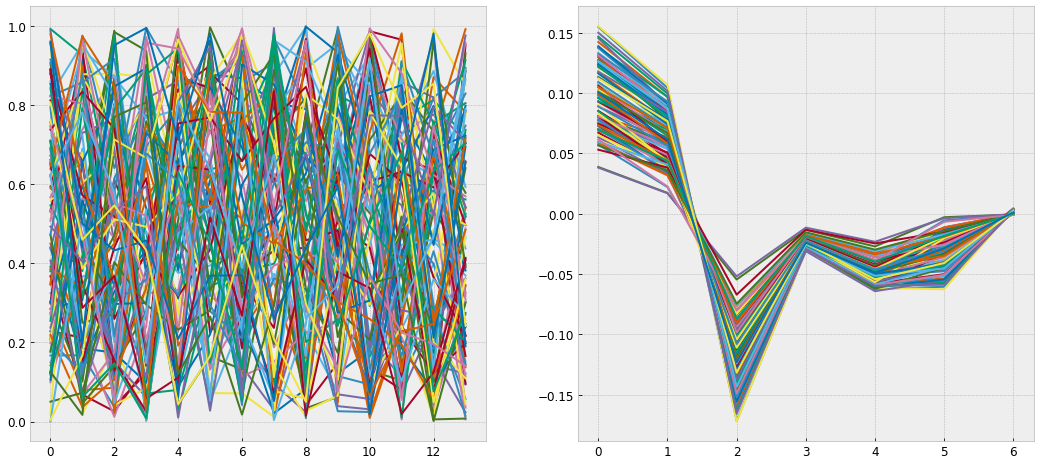

In [4]:
from models import get_model

# MODEL_TYPE = "LSTM_Simple_WO_Regions"
MODEL_TYPE = "LSTM4EachDay_WO_Regions"

model, reduce_regions2batch = get_model(MODEL_TYPE,
                                            input_days=WINDOW_LENGTH,
                                            output_days=PREDICT_STEPS,
                                            n_features=n_features,
                                            n_regions=n_regions)


x_rand = np.random.random((100, WINDOW_LENGTH, 1))
y_rand_pred = model(x_rand)

plt.subplot(121)
plt.plot(x_rand[:,:,0].T)
plt.subplot(122)
plt.plot(np.array(y_rand_pred[:,:,0]).T)
plt.show()

### Preparing data for training

In [5]:
def get_data(filtered, normalize=False):
    if filtered == False:
        x,y= np.copy(daily_cases), np.copy(daily_cases)
    else:
        x,y= np.copy(daily_filtered), np.copy(daily_filtered)
    
    
    x = per_million(x, population)
    y = per_million(y, population)
    if normalize:
        
        x, xs=normalize_for_nn(x, None if type(normalize)==bool else normalize)
        y, xs=normalize_for_nn(y, xs)
        return x.T,y.T,xs
    else:
        return x.T,y.T

In [6]:

x_data, y_data, x_data_scalers = get_data(False,normalize=True)
x_dataf, y_dataf, x_data_scalersf = get_data(True, normalize=True)

x_data, y_data, _ = get_data(TRAINING_DATA_TYPE=="Filtered",normalize=x_data_scalers)

features = np.zeros((n_regions,0))


tmp = split_on_time_dimension(x_data.T, y_data.T, features, WINDOW_LENGTH, PREDICT_STEPS, 
                              k_fold=3, test_fold=2, reduce_last_dim=reduce_regions2batch,
                              only_train_test=True, debug=True)
X_train, X_train_feat, Y_train, X_val, X_val_feat, Y_val, X_test, X_test_feat, Y_test = tmp

if len(X_train.shape) == 2:
    X_train, X_train_feat, Y_train = np.expand_dims(X_train,-1),np.expand_dims(X_train_feat,-1),np.expand_dims(Y_train,-1)
    X_val, X_val_feat, Y_val = np.expand_dims(X_val,-1),np.expand_dims(X_val_feat,-1),np.expand_dims(Y_val,-1)
    X_test, X_test_feat, Y_test = np.expand_dims(X_test,-1),np.expand_dims(X_test_feat,-1),np.expand_dims(Y_test,-1)

print("Train", X_train.shape, Y_train.shape, X_train_feat.shape)
print("Val", X_val.shape, Y_val.shape, X_val_feat.shape)
print("Test", X_test.shape, Y_test.shape,X_test_feat.shape)

X_train = np.concatenate([X_train, X_test], 0)
X_train_feat = np.concatenate([X_train_feat, X_test_feat], 0)
Y_train = np.concatenate([Y_train, Y_test], 0)

print("Train", X_train.shape, Y_train.shape, X_train_feat.shape)
print("Val", X_val.shape, Y_val.shape, X_val_feat.shape)


NORMALIZING; Data: (25, 125) expected (regions, days)
NORMALIZING; Data: (25, 125) expected (regions, days)
NORMALIZING; Data: (25, 125) expected (regions, days)
NORMALIZING; Data: (25, 125) expected (regions, days)
NORMALIZING; Data: (25, 125) expected (regions, days)
NORMALIZING; Data: (25, 125) expected (regions, days)

k_folds 3
samples per fold 41
0, val start a=82, test start b=82, test end c=123, 125
x_train:(25, 82) y_train:(25, 82) x_val:(25, 0) y_val:(25, 0) x_test:(25, 41) y_test:(25, 41)
selecting 84 samples from training part
selecting 41 samples from validation part
selecting 41 samples from testing part
Train (2100, 14, 1) (2100, 7, 1) (2100, 0, 1)
Val (0, 14, 1) (0, 7, 1) (0, 0, 1)
Test (1025, 14, 1) (1025, 7, 1) (1025, 0, 1)
Train (3125, 14, 1) (3125, 7, 1) (3125, 0, 1)
Val (0, 14, 1) (0, 7, 1) (0, 0, 1)


Undersampling. Expectated data (regions, days). Got (25, 125)
segments per district=  [ 9 10  9  3 10 10 10  7  9 10 10  4 10  9  8  7  9  9  7  7 10  9  9  9
 10]
25


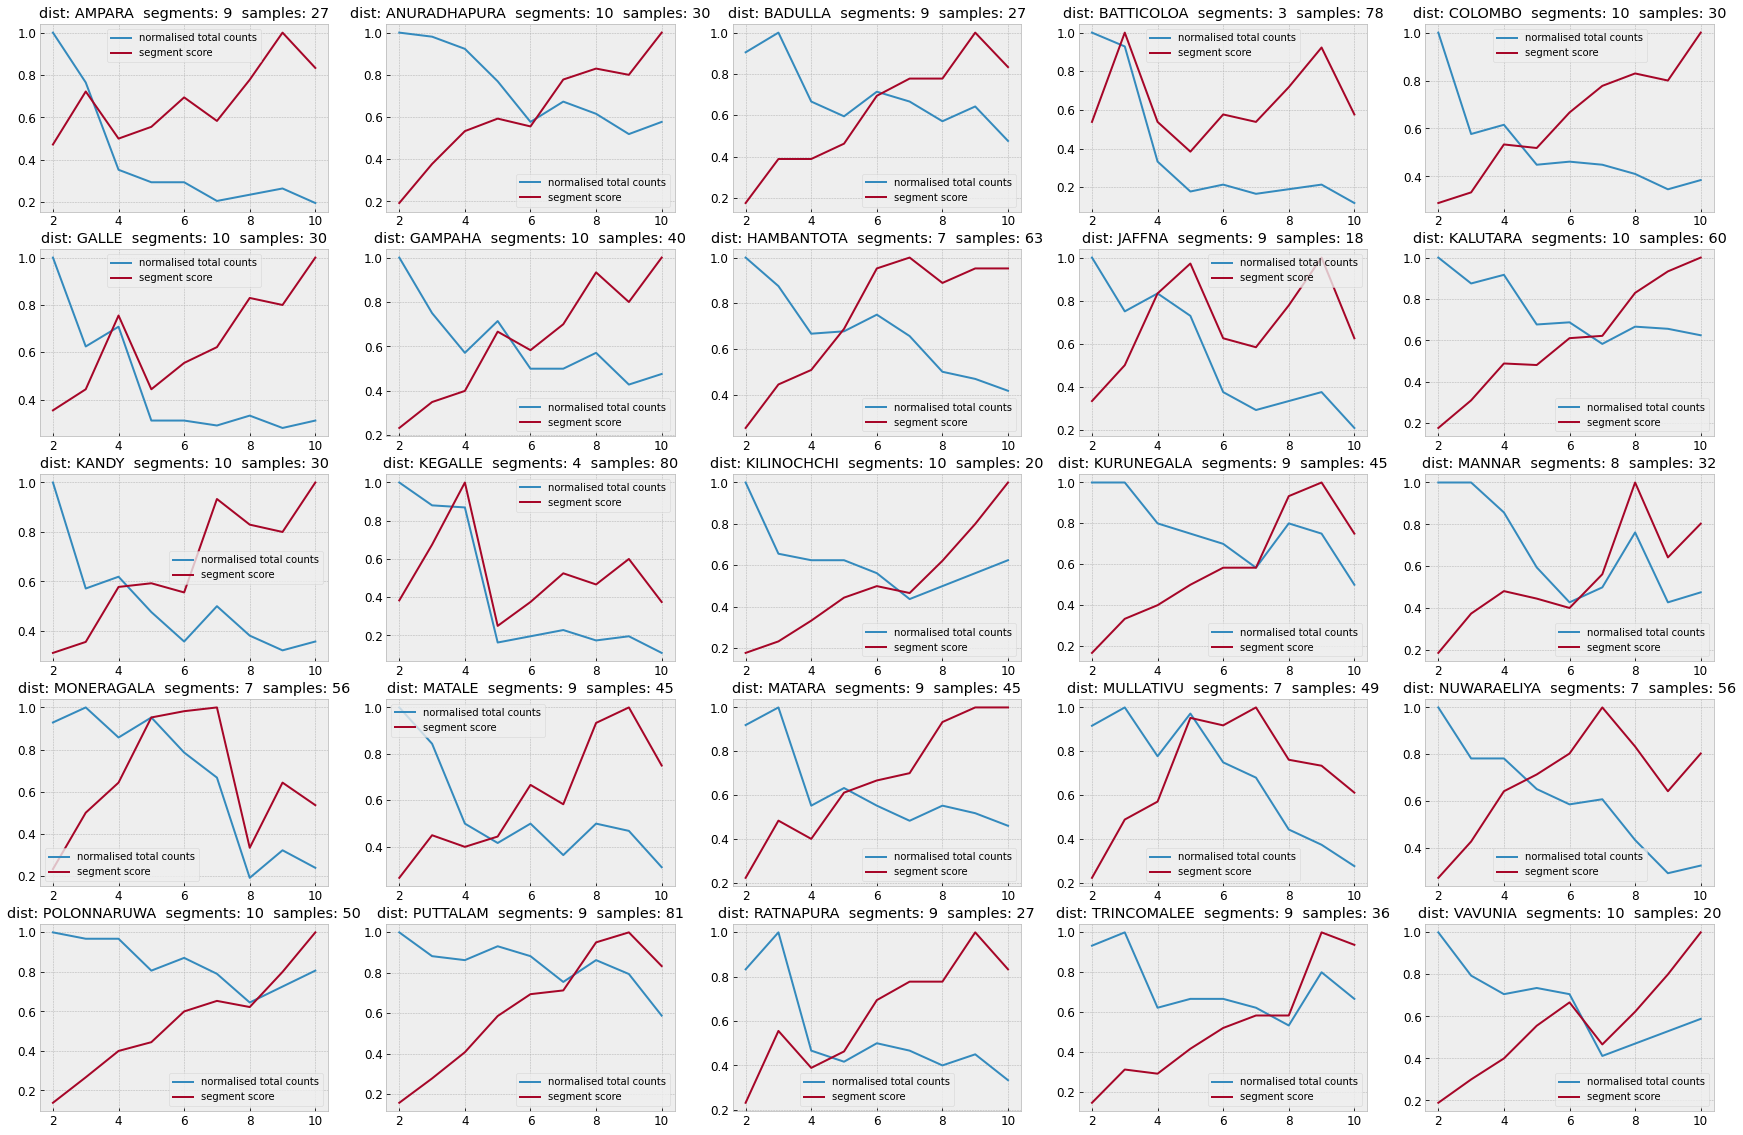

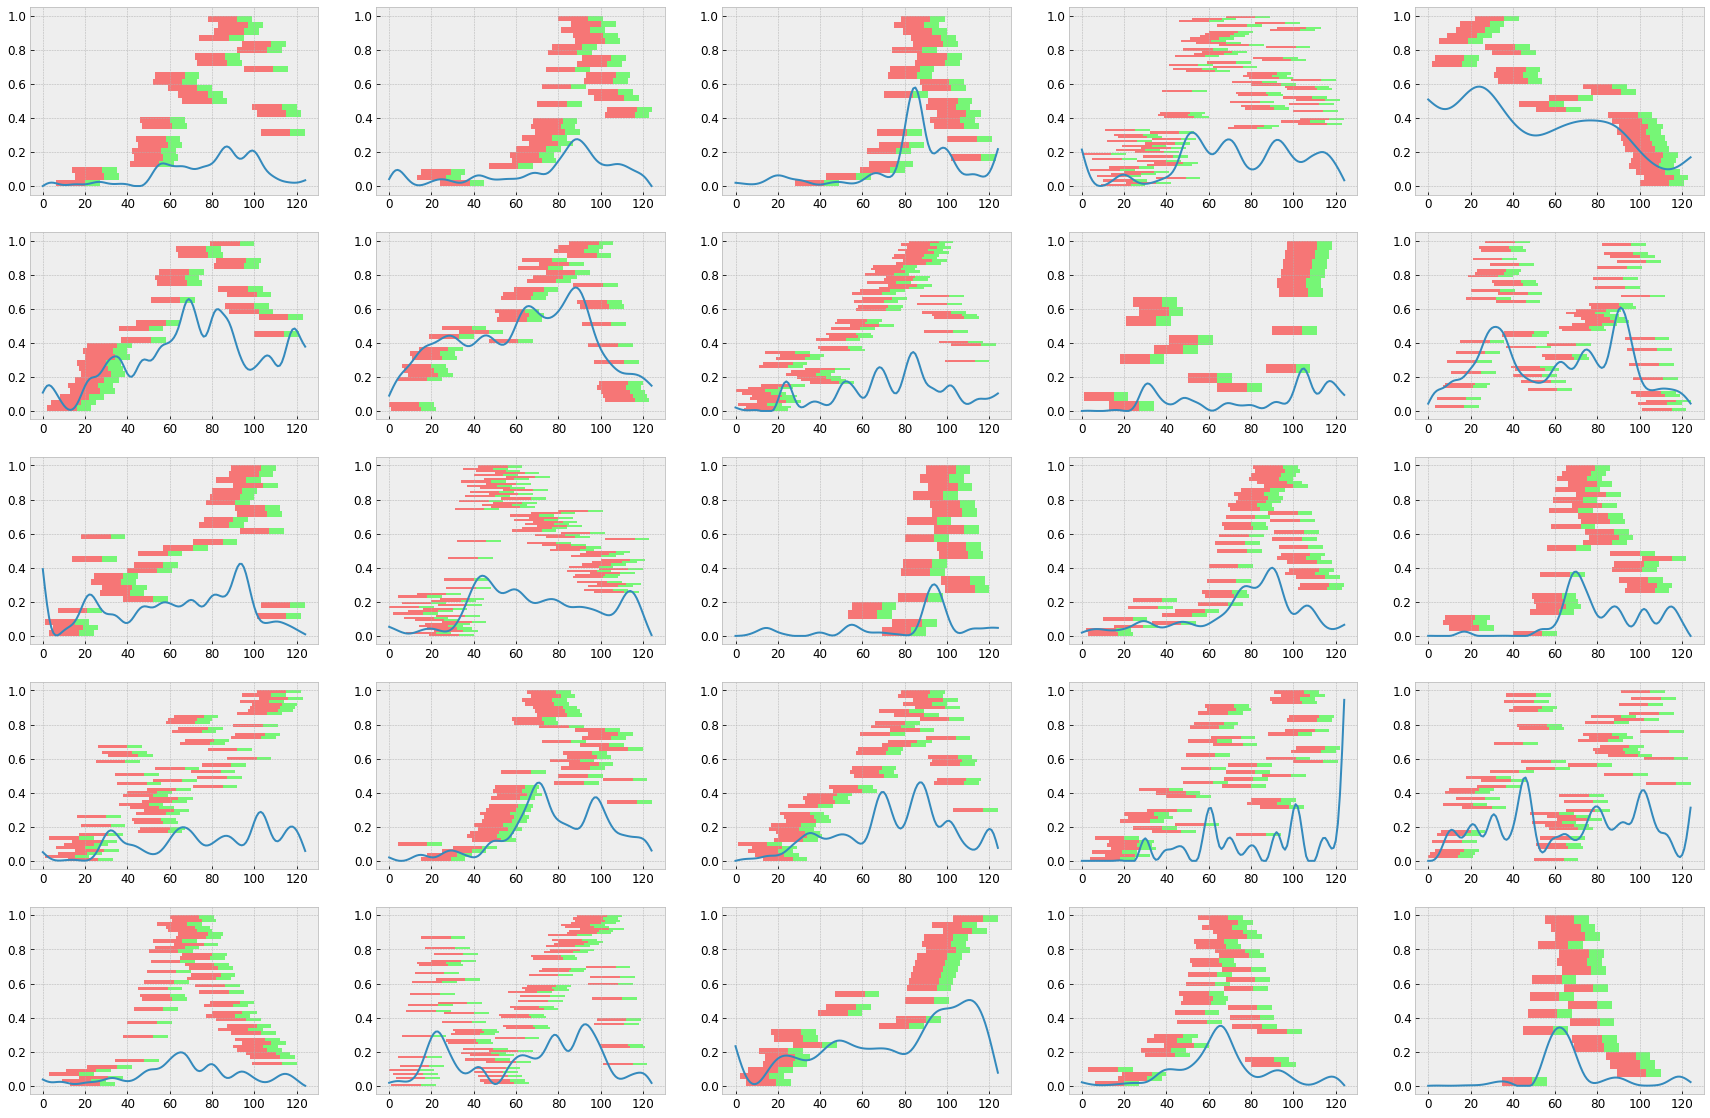

In [7]:
from undersampling import undersample
UNDERSAMPLING = "Reduce"
if UNDERSAMPLING == "Reduce" and reduce_regions2batch:  # Currently optimal undersampling supports independatly on regions.
    x_train_opt, y_train_opt = undersample(x_data.T, y_data.T, WINDOW_LENGTH, PREDICT_STEPS, region_names, True)
    X_train = x_train_opt
    Y_train = y_train_opt


In [8]:

train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_data = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_data = test_data.batch(BATCH_SIZE)

freq, xcheck = np.histogram(np.concatenate(X_train,-1).mean(0))

NORMALIZING; Data: (25, 125) expected (regions, days)
NORMALIZING; Data: (25, 125) expected (regions, days)


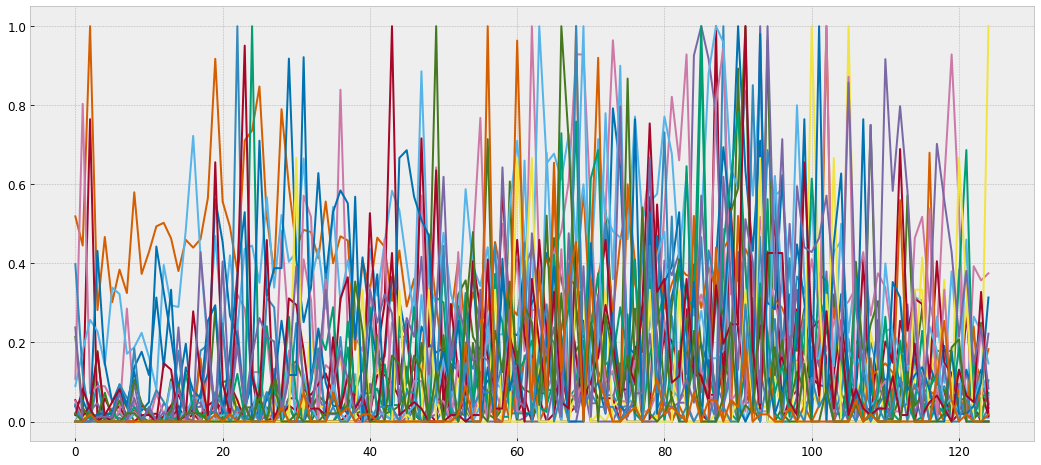

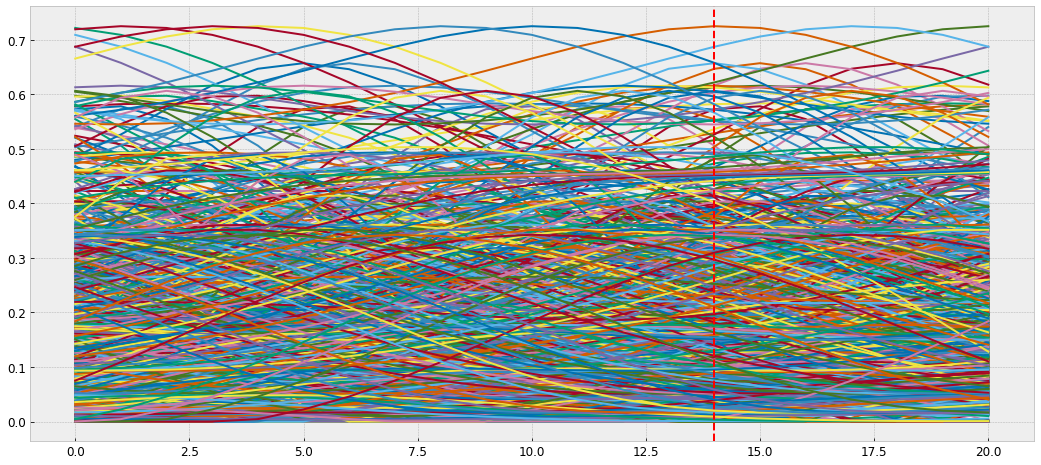

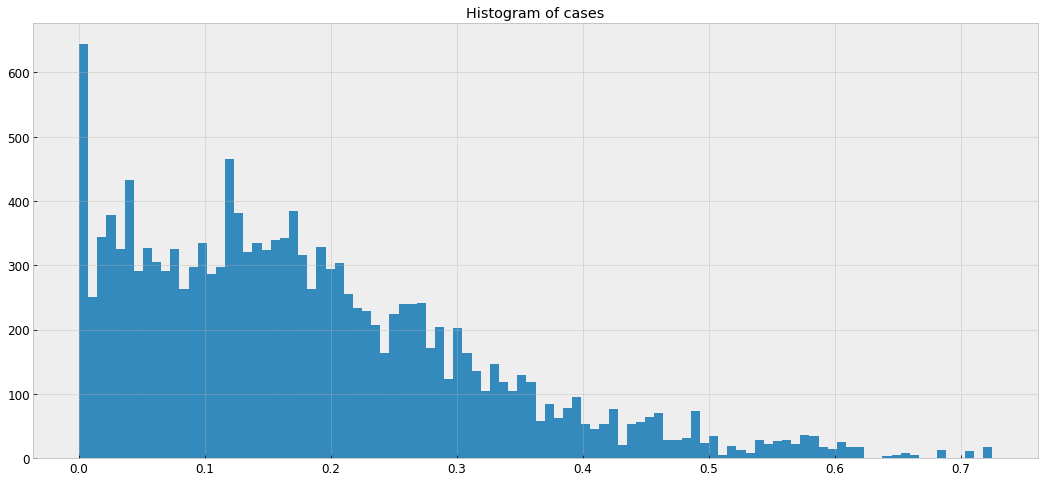

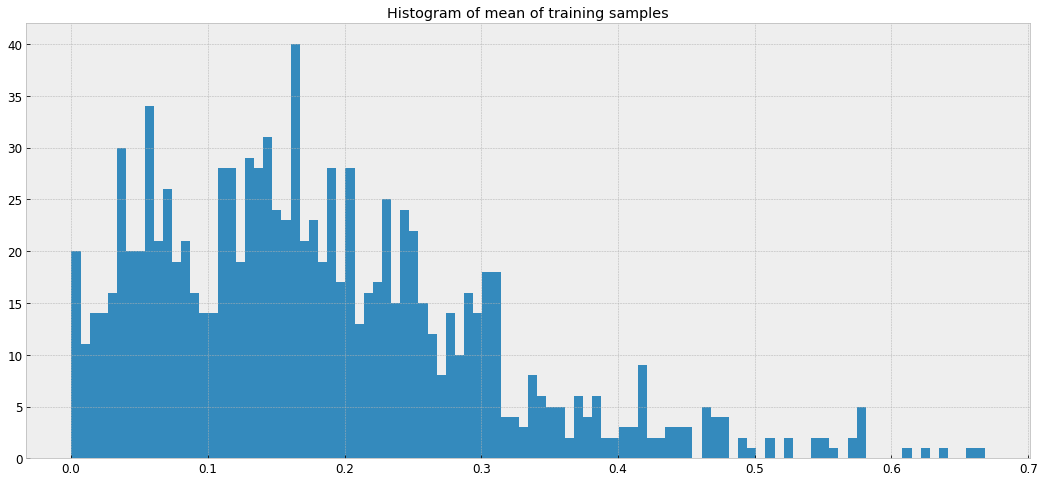

In [9]:
x_data, y_data, _ = get_data(filtered=False, normalize=True)
plt.plot(x_data)
plt.show()

for i in range(X_train.shape[-1]):
    plt.plot(np.concatenate([X_train[:,:,i],Y_train[:,:,i]],1).T)
plt.axvline(X_train.shape[1],color='r',linestyle='--')
plt.show()

plt.hist(X_train.reshape(-1), bins=100)
plt.title("Histogram of cases")
plt.show()

plt.hist(np.concatenate(X_train,-1).mean(0), bins=100)
plt.title("Histogram of mean of training samples")
plt.show()


## Train

In [10]:
(1/np.log(freq))**3*10

array([0.06723356, 0.06472228, 0.05889762, 0.06985842, 0.09685166,
       0.17818286, 0.23393574, 0.50353524, 0.65173308, 2.39870764])

In [11]:

from trainer import get_loss_f
loss_f = get_loss_f(UNDERSAMPLING, xcheck, freq)

2.4.0


In [12]:
fmodel_name = DATASET + "_" + MODEL_TYPE + "_" + TRAINING_DATA_TYPE

print(fmodel_name)
print("Train", X_train.shape, Y_train.shape, X_train_feat.shape)
print("Val", X_val.shape, Y_val.shape, X_val_feat.shape)
print("Test", X_test.shape, Y_test.shape,X_test_feat.shape)


folder = time.strftime('%Y.%m.%d-%H.%M.%S', time.localtime())+"_"+fmodel_name
os.makedirs('./logs/' + folder)
tensorboard = TensorBoard(log_dir='./logs/' + folder, write_graph=True, histogram_freq=1, write_images=True)
tensorboard.set_model(model)


opt = tf.keras.optimizers.Adam(lr=lr)
def eval_metric(y_true, y_pred):  
    
    return np.mean((np.squeeze(y_true)-np.squeeze(y_pred))**2)**0.5

train_metric = []
val_metric = []
test_metric = []
best_test_value = 1e10
for epoch in range(EPOCHS):
    losses = []
    for x,y in train_data:
        plt.show()
        with tf.GradientTape() as tape:
            y_pred = model(x, training=True)
            loss = loss_f(y, y_pred, x)

        grad = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(grad, model.trainable_variables))
        losses.append(loss)

        print(f"\r Epoch {epoch}: mean loss = {np.mean(losses):.5f}", end='')
    # add metric value of the prediction (from training data)
    pred_train_y = model(X_train, training=False)
    train_metric.append(eval_metric(Y_train,pred_train_y))
    # add metric value of the prediction (from testing data)
    pred_test_y = model(X_test, training=False)
    test_metric.append(eval_metric(Y_test,pred_test_y))
    
    if test_metric[-1] < best_test_value:
        best_test_value = test_metric[-1]
        print(f" Best test metric {best_test_value}. Saving model...")
        model.save("temp.h5")

Sri Lanka_LSTM4EachDay_WO_Regions_Filtered
Train (1075, 14, 1) (1075, 7, 1) (3125, 0, 1)
Val (0, 14, 1) (0, 7, 1) (0, 0, 1)
Test (1025, 14, 1) (1025, 7, 1) (1025, 0, 1)
 Epoch 0: mean loss = 0.03156 Best test metric 0.10372352656367544. Saving model...
 Epoch 1: mean loss = 0.01419 Best test metric 0.09234234413420513. Saving model...
 Epoch 2: mean loss = 0.01132 Best test metric 0.08840831999603317. Saving model...
 Epoch 3: mean loss = 0.01008 Best test metric 0.08512620472235666. Saving model...
 Epoch 4: mean loss = 0.00949 Best test metric 0.08265547729363057. Saving model...
 Epoch 5: mean loss = 0.00865 Best test metric 0.0820961881002403. Saving model...
 Epoch 6: mean loss = 0.00803 Best test metric 0.07838457659794999. Saving model...
 Epoch 7: mean loss = 0.00754 Best test metric 0.07464173502986596. Saving model...
 Epoch 8: mean loss = 0.00722 Best test metric 0.07210544467505998. Saving model...
 Epoch 9: mean loss = 0.00662 Best test metric 0.07080740591905416. Saving m

In [ ]:
freq

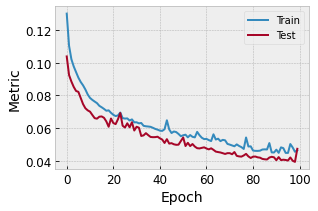

In [13]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.ion()
plt.plot(train_metric, label='Train')
plt.plot(test_metric, label='Test')
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.ioff()
plt.show()

In [14]:
model =  tf.keras.models.load_model("temp.h5")
model.save("models/"+fmodel_name+".h5")


